In [1]:
### Imports and metadata ###

import os
import sys
import time
import numpy as np
import tensorflow as tf 
from keras.layers import *
from keras.models import Model
import visualize
from Autoencoder import AutoEncoder
from AutoEncoderQuat import AutoEncoderQuat
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Using TensorFlow backend.


In [2]:
### Load data ###

data_path = ''

train = np.genfromtxt(os.path.join(data_path,'training.csv'), delimiter=',')
train = train / np.max(train)
#test = np.genfromtxt(os.path.join(data_path,'testing.csv'), delimiter=',')[1:]

In [3]:
### Setup network ###

input_size = train.shape[1]
coding_dims = [40,30,20,10]

autoencoder = AutoEncoder(input_dim=input_size,
                          coding_dims=coding_dims,
                          learning_rate=1e-7,
                          batch_size=32)

autoencoder.load_from_file('run1.h5')

Autoencoder.py:139: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("en..., inputs=Tensor("in...)`
  output=self.layers_encoder[-1].output)


In [4]:
### Make predictions ###

encoded_hands = autoencoder.encode(train)
decoded_hands = autoencoder.decode(encoded_hands)

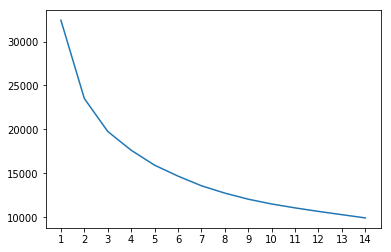

In [5]:
# do some k-means I guess

def kmloss(X):
    return np.sum(X.min(axis=1)**2)

check_up_to = 15

num_clusters_loss = []
for i in range(1,check_up_to):
    km = KMeans(n_clusters=i, n_jobs=-1)
    kmvals = km.fit_transform(encoded_hands)
    num_clusters_loss.append(kmloss(kmvals))
    
plt.plot(range(1,check_up_to),num_clusters_loss)
_ = plt.xticks(range(1,check_up_to))
# use the elbow method on the plotted curve to figure out number of clusers

('number of clusters detected:', 8)


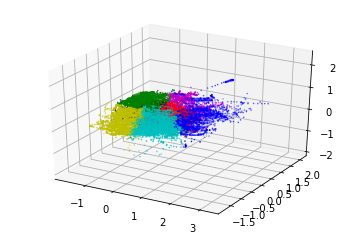

In [6]:
# do some stupid pseudo second derivative stuff to find the elbow point
principal_components = PCA(n_components=3).fit_transform(encoded_hands)
n_clusters = len(list(filter(lambda x: x>100, np.diff(np.gradient(num_clusters_loss)))))-1
print("number of clusters detected:", n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=-1)
cluster_labels = np.expand_dims(km.fit_predict(encoded_hands), axis=1)

def cluster_to_color(cluster):
    colors = 'bgrcmykw'
    return colors[cluster]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcc = np.concatenate((principal_components, cluster_labels), axis=1)
for cluster in range(n_clusters):
    c = pcc[pcc[:,3] == cluster]
    ax.scatter(c[:,0], c[:,1], c[:,2], s=0.3, c=cluster_to_color(cluster))

<IPython.core.display.Javascript object>


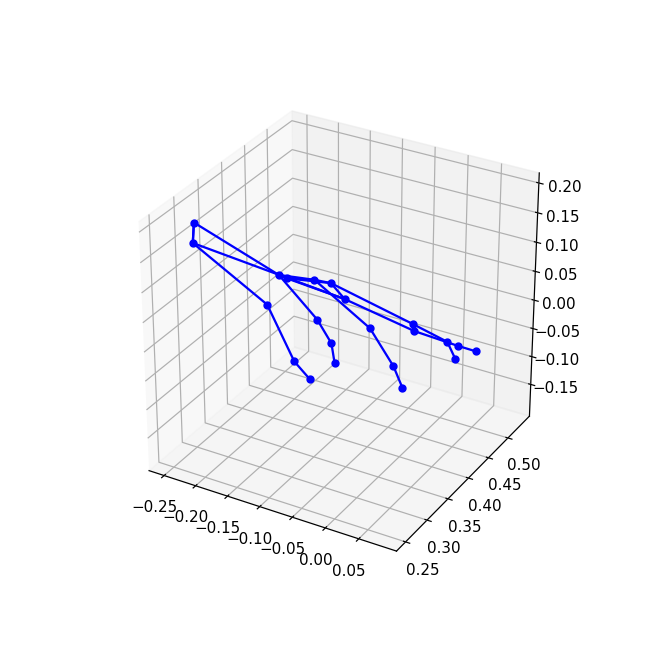

<IPython.core.display.Javascript object>


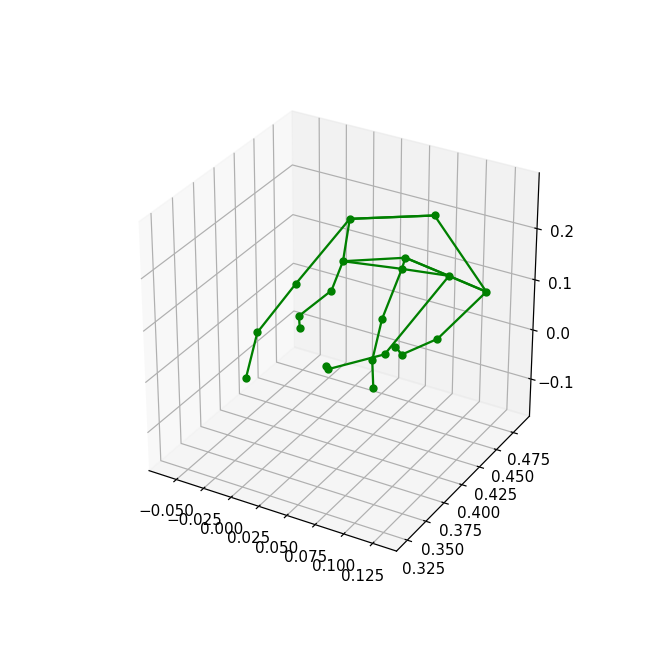

<IPython.core.display.Javascript object>


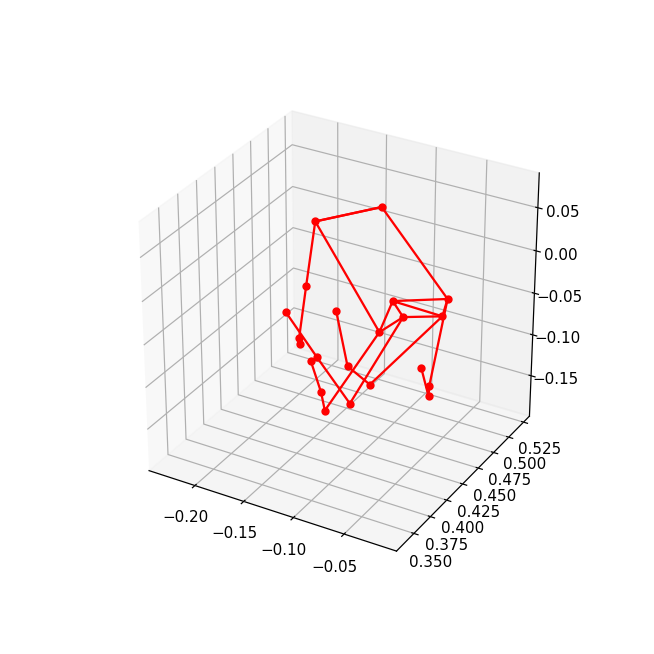

<IPython.core.display.Javascript object>


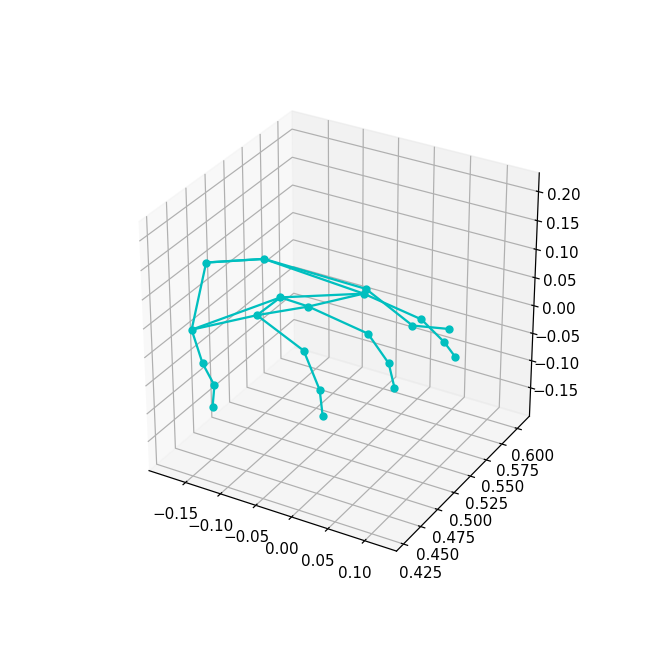

<IPython.core.display.Javascript object>


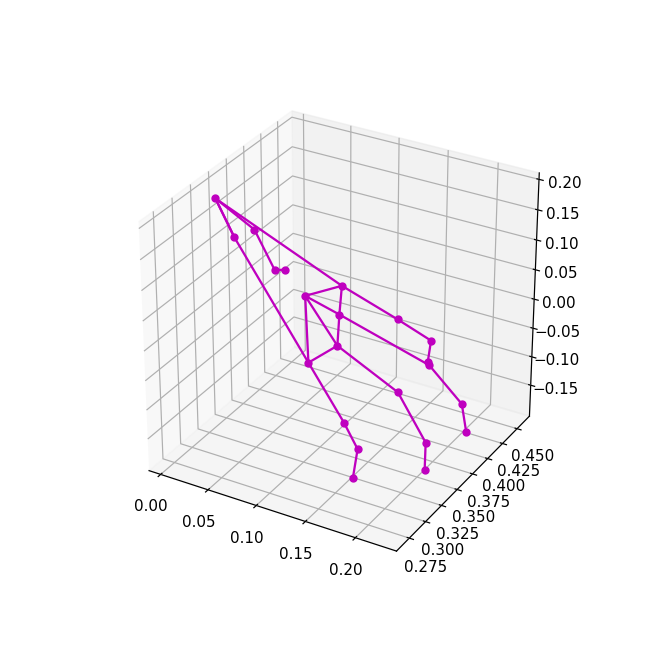

<IPython.core.display.Javascript object>


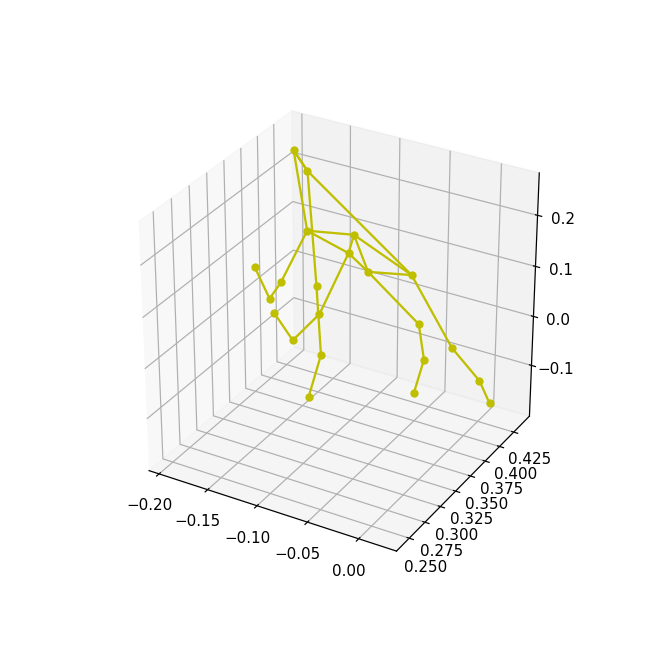

<IPython.core.display.Javascript object>


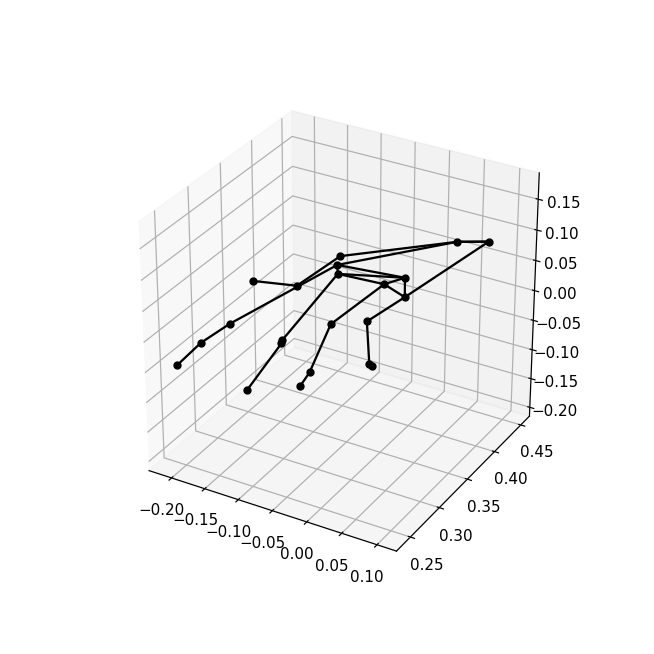

<IPython.core.display.Javascript object>


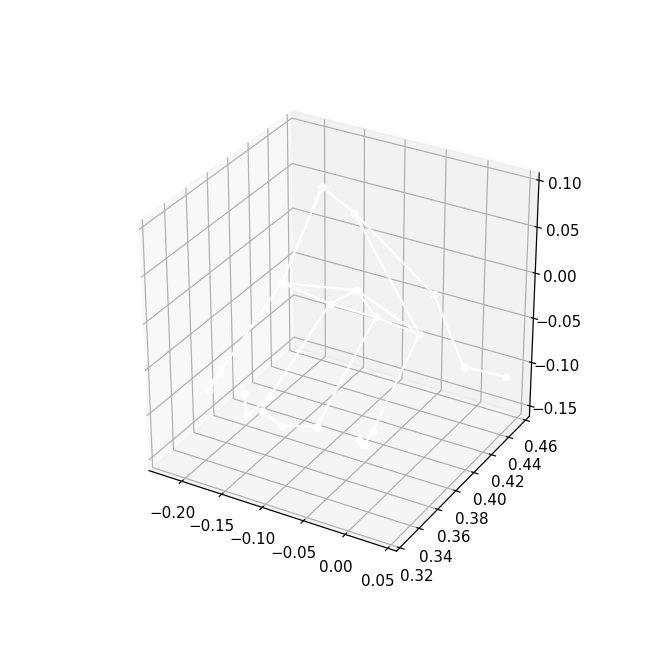

In [7]:
%matplotlib notebook
reload(visualize)
encc = np.concatenate((encoded_hands, cluster_labels), axis=1)
for cluster in range(n_clusters):
    c = encc[encc[:,coding_dims[-1]] == cluster]
    choice = c[np.random.choice(range(c.shape[0]))][:-1]
    dec_choice = autoencoder.decode(np.expand_dims(choice, axis=0))
    visualize.plot_hand(dec_choice[0,:], color=cluster_to_color(cluster))